<a href="https://colab.research.google.com/github/joshuaalpuerto/ML-guide/blob/main/Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightning -q --progress-bar off

# Why?

- I'm curious of how transformer architecture look like under the hood.
- Improve my understanding why and how things work.(help me debug it and other models)
   - Interpret it's result not just simply saying because its a "blackbox"
- Improve myself as Machine learning engineer.

## Preparation

Our goal is to have our decoder model output something base on our prompt.

If we have prompts: `what is life` and `life is what` it should output `awesome`

- Having our vocabulary setup
- Creating our training dataset

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Create a simple vocabulary
token_to_id = {
    "what": 0,
    "is": 1,
    "life": 2,
    "<EOS>": 3,
    "awesome": 4,
}

id_to_token = dict(map(reversed, token_to_id.items()))

# to visualize the reasoning behing inputs and outputs/labels check this visualization
# https://colab.research.google.com/github/StatQuest/decoder_transformer_from_scratch/blob/main/decoder_transformers_with_pytorch_and_lightning_v2.ipynb#scrollTo=752cda95-7e7e-430a-8c1a-4afc9670379b

## NOTE: Because we are using a Decoder-Only Transformer, the inputs contain
##       the questions ("what is life?" and "life is what?") followed
##       by an <EOS> token followed by the response, "awesome".
##       This is because all of those tokens will be used as inputs to the Decoder-Only
##       Transformer during Training.
## ALSO NOTE: When we train this way, it's called "teacher forcing".
##       Teacher forcing helps us train the neural network faster.
inputs = torch.tensor([[token_to_id["what"], ## input #1: what is life <EOS> awesome
                        token_to_id["is"],
                        token_to_id["life"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"]],

                       [token_to_id["life"], # input #2: life is what <EOS> awesome
                        token_to_id["is"],
                        token_to_id["what"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"]]])

## NOTE: Because we are using a Decoder-Only Transformer the outputs, or
##       the predictions, are the input questions (minus the first word) followed by
##       <EOS> awesome <EOS>.  The first <EOS> means we're done processing the input question
##       and the second <EOS> means we are done generating the output.
##       See the illustration above for more details.
labels = torch.tensor([[token_to_id["is"],
                        token_to_id["life"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"],
                        token_to_id["<EOS>"]],

                       [token_to_id["is"],
                        token_to_id["what"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"],
                        token_to_id["<EOS>"]]])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

## Position encoding

In transformer models, **positional embedding** is a technique used to inject information about the order of tokens in a sequence since transformers, unlike recurrent models, process inputs in parallel without inherent sequential ordering. To capture this positional information, sine and cosine functions are often employed.

The idea is that `words` could repeat in different parts of the sentence, but we should only adjust them a bit base on their position (otherwise adjusting them with big numbers because of their `position` will overpower   their semantic meaning) - [Youtube](https://https://www.youtube.com/watch?v=1biZfFLPRSY&t=243s)

In [3]:
import torch.nn as nn

class PositionEncodingWithLooping(nn.Module):
  def __init__(self, d_model=2, max_len=6):

      super().__init__()

      positional_embedding = torch.zeros(max_len, d_model)
      ## loop through each tensor to create a sine/cosine pair
      ## tensor([[0., 0.],
      ##  [0., 0.],
      ##  [0., 0.],
      ##  [0., 0.],
      ##  [0., 0.],
      ##  [0., 0.]])
      for position, token in enumerate(positional_embedding):
        for d_index in range(0, d_model - 1):
            index_by_two = 2 * d_index
            formula = position / (torch.tensor(10000.0) ** (index_by_two / d_model))

            # sine will be for even numbers
            positional_embedding[position][index_by_two] = torch.sin(formula)
            # cosine will be for odd numbers
            positional_embedding[position][index_by_two + 1] = torch.cos(formula)

      self.pe = positional_embedding

  def forward(self, word_embeddings):
    # Get only the same size of word_embeddings from `pe`
    return word_embeddings + self.pe[:word_embeddings.size(0), :]

In [ ]:
# @title Optimized version of the loop above PositionEncoding

class PositionEncoding(nn.Module):
    def __init__(self, d_model=2, max_len=6):

        super().__init__()


        ## Now we create a lookup table, pe, of position encoding values and initialize all of them to 0.
        ## To do this, we will make a matrix of 0s that has max_len rows and d_model columns.
        ## for example...
        ## torch.zeros(3, 2)
        ## ...returns a matrix of 0s with 3 rows and 2 columns...
        ## tensor([[0., 0.],
        ##         [0., 0.],
        ##         [0., 0.]])
        ## We do this to create a placeholder, so computation below will be much simpler.
        pe = torch.zeros(max_len, d_model)

        ## Now we create a sequence of numbers for each position that a token can have in the input (or output).
        ## For example, if the input tokens where "I'm happy today!", then "I'm" would get the first
        ## position, 0, "happy" would get the second position, 1, and "today!" would get the third position, 2.
        ## NOTE: Since we are going to be doing math with these position indices to create the
        ## positional encoding for each one, we need them to be floats rather than ints.
        ##
        ## Lastly, .unsqueeze(1) converts the single list of numbers that torch.arange creates into a matrix with
        ## one row for each index, and all of the indices in a single column. So if "max_len" = 3, then we
        ## would create a matrix with 3 rows and 1 column like this...
        ##
        ## torch.arange(start=0, end=3, step=1, dtype=torch.float).unsqueeze(1)
        ##
        ## ...returns...
        ##
        ## tensor([[0.],
        ##         [1.],
        ##         [2.]])
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)


        ## Here is where we start doing the math to determine the y-axis coordinates on the
        ## sine and cosine curves.
        ##
        ## The positional encoding equations used in "Attention is all you need" are...
        ##
        ## PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
        ## PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        ##
        ## ...and we see, within the sin() and cos() functions, we divide "pos" by some number that depends
        ## on the index (i) and total number of PE values we want per token (d_model).
        ##
        ## NOTE: When the index, i, is 0 then we are calculating the y-axis coordinates on the **first pair**
        ##       of sine and cosine curves. When i=1, then we are calculating the y-axis coordiantes on the
        ##       **second pair** of sine and cosine curves. etc. etc.
        ##
        ## Now, pretty much everyone calculates the term we use to divide "pos" by first, and they do it with
        ## code that looks like this...
        ##
        ## div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float() * -(math.log(10000.0) / d_model))
        ##
        ## Now, at least to me, it's not obvious that div_term = 1/(10000^(2i/d_model)) for a few reasons:
        ##
        ##    1) div_term wraps everything in a call to torch.exp()
        ##    2) It uses log()
        ##    2) The order of the terms is different
        ##
        ## The reason for these differences is, presumably, trying to prevent underflow (getting too close to 0).
        ## So, to show that div_term = 1/(10000^(2i/d_model))...
        ##
        ## 1) Swap out math.log() for torch.log() (doing this requires converting 10000.0 to a tensor, which is my
        ##    guess for why they used math.log() instead of torch.log())...
        ##
        ## torch.exp(torch.arange(start=0, end=d_model, step=2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        ##
        ## 2) Rearrange the terms...
        ##
        ## torch.exp(-1 * (torch.log(torch.tensor(10000.0)) * torch.arange(start=0, end=d_model, step=2).float() / d_model))
        ##
        ## 3) Pull out the -1 with exp(-1 * x) = 1/exp(x)
        ##
        ## 1/torch.exp(torch.log(torch.tensor(10000.0)) * torch.arange(start=0, end=d_model, step=2).float() / d_model)
        ##
        ## 4) Use exp(a * b) = exp(a)^b to pull out the 2i/d_model term...
        ##
        ## 1/torch.exp(torch.log(torch.tensor(10000.0)))^(torch.arange(start=0, end=d_model, step=2).float() / d_model)
        ##
        ## 5) Use exp(log(x)) = x to get the original form of the denominator...
        ##
        ## 1/(torch.tensor(10000.0)^(torch.arange(start=0, end=d_model, step=2).float() / d_model))
        ##
        ## 6) Bam.
        ##
        ## So, that being said, I don't think underflow is actually that big an issue. In fact, some coder at Hugging Face
        ## also doesn't think so, and their code for positional encoding in DistilBERT (a streamlined version of BERT, which
        ## is a transformer model)
        ## calculates the values directly - using the form of the equation found in original Attention is all you need
        ## manuscript. See...
        ## https://github.com/huggingface/transformers/blob/455c6390938a5c737fa63e78396cedae41e4e87e/src/transformers/modeling_distilbert.py#L53
        ## So I think we can simplify the code, but I'm also writing all these comments to show that it is equivalent to what
        ## you'll see in the wild...
        ##
        ## Now let's create an index for the embedding positions to simplify the code a little more...
        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        ## NOTE: Setting step=2 results in the same sequence numbers that we would get if we multiplied i by 2.
        ##       So we can save ourselves a little math by just setting step=2.

        ## And now, finally, let's create div_term...
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)

        ## Now we calculate the actual positional encoding values. Remember 'pe' was initialized as a matrix of 0s
        ## with max_len (max number of input tokens) rows and d_model (number of embedding values per token) columns.
        pe[:, 0::2] = torch.sin(position * div_term) ## every other column, starting with the 1st, has sin() values
        pe[:, 1::2] = torch.cos(position * div_term) ## every other column, starting with the 2nd, has cos() values
        ## NOTE: If the notation for indexing 'pe[]' looks cryptic to you, read on...
        ##
        ## First, let's look at the general indexing notation:
        ##
        ## For each row or column in matrix we can select elements in that
        ## row or column with the following indexs...
        ##
        ## i:j:k = select elements between i and j with stepsize = k.
        ##
        ## ...where...
        ##
        ## i defaults to 0
        ## j defaults to the number of elements in the row, column or whatever.
        ## k defaults to 1
        ##
        ## Now that we have looked at the general notation, let's look at specific
        ## examples so that we can understand it.
        ##
        ## We'll start with: pe[:, 0::2]
        ##
        ## The stuff that comes before the comma (in this case ':') refers to the rows we want to select.
        ## The ':' before the comma means "select all rows" because we are not providing specific
        ## values for i, j and k and, instead, just using the default values.
        ##
        ## The stuff after the comma refers to the columns we want to select.
        ## In this case, we have '0::2', and that means we start with
        ## the first column (column =  0) and go to the end (using the default value for j)
        ## and we set the stepsize to 2, which means we skip every other column.
        ##
        ## Now to understand pe[:, 1::2]
        ##
        ## Again, the stuff before the comma refers to the rows, and, just like before
        ## we use default values for i,j and k, so we select all rows.
        ##
        ## The stuff that comes after the comma refers to the columns.
        ## In this case, we start with the 2nd column (column = 1), and go to the end
        ## (using the default value for 'j') and we set the stepsize to 2, which
        ## means we skip every other column.
        ##
        ## NOTE: using this ':' based notation is called "indexing" and also called "slicing"

        ## Now we "register 'pe'.
        self.register_buffer('pe', pe) ## "register_buffer()" ensures that
                                       ## 'pe' will be moved to wherever the model gets
                                       ## moved to. So if the model is moved to a GPU, then,
                                       ## even though we don't need to optimize 'pe', it will
                                       ## also be moved to that GPU. This, in turn, means
                                       ## that accessing 'pe' will be relatively fast copared
                                       ## to having a GPU have to get the data from a CPU.

    ## Because this class, PositionEncoding, inherits from nn.Module, the forward() method
    ## is called by default when we use a PositionEncoding() object.
    ## In other words, after we create a PositionEncoding() object, pe = PositionEncoding(),
    ## then pe(word_embeddings) will call forward() and so this is where
    ## we will add the position encoding values to the word embedding values
    def forward(self, word_embeddings):

        return word_embeddings + self.pe[:word_embeddings.size(0), :] ## word_embeddings.size(0) = number of embeddings
                                                                      ## NOTE: That second ':' is optional and
                                                                      ## we could re-write it like this:
                                                                      ## self.pe[:word_embeddings.size(0)]

# Attention

In [4]:
import torch.nn as nn
import torch.nn.functional as F

## NOTE: our code only wors with one input(not batch)
class Attention(nn.Module):
  def __init__(self, d_model=2):

      super().__init__()

      # Initialize the weights for the Query, Key and Value
      # This is a trainable parameters that our model will learn.
      self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
      self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
      self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)

      self.d_model=d_model

  ## NOTE: the goal here is to adjust meaning of the token based on how the sentence is contruct.
  ## So given it's positional embedding, we further adjust the embedding base on the tokens around it.
  def forward(self, position_embeddings, mask = None):
      # Check if input is a single sequence (2D)(single input) or a batch of sequences (3D)
      is_batch = position_embeddings.dim() > 2

      if not is_batch:
          # Add batch dimension if not present
          position_embeddings = position_embeddings.unsqueeze(0)  # (1, seq_len, dim)

      q = self.W_q(position_embeddings)
      k = self.W_k(position_embeddings)
      v = self.W_v(position_embeddings)

      ## We cannot use k.T because this will not work when we have batches (batch, token_len, embeddings)
      ## k = [batch[token1[-0.2033,  0.4328, -0.5559], ..], ...] (2, 4, 3)
      ## k.T = [batch[token1[-0.334,  0.991], ..], ...] (3, 4, 2) (incorrect)
      ## We wil use `transpose` to modify particular dimension
      ## Note: We do transpose K because we need to compute the relationship of each token against each other.
      ## So each token should have a dimension length equals to token length
      ##
      ## q = (2, 4, 3) (batch, token_len, embeddings)
      ## k.T = (2, 3, 4) (batch, embeddings, token_len) we transpose the inner layer
      ##
      ## Q (token_len, dim_len) = [[-0.2033,  0.4], [-0.4144,  0.0525], [0.1195, -0.2213], [-0.6304, -1.4384]]
      ## K.T (dim_len, token_len) = [[-0.5559, -0.8518,  0.3156, -0.7806], [-0.5472, -0.5425,  0.298, 0.2231]]
      ##
      ## Why?
      ## To calculate similarity scores/dot_product of each token features against each other tokens features
      ## Similar tokens in a concept space would have bigger attention scores.
      ## Q1 embeddings [-0.2033,  0.4] x K1 embeddings [-0.5559, -0.5472]
      ## Q2 embeddings [-0.4144,  0.0525] x K2 embeddings [-0.8518, -0.5425]
      ## Q3 embeddings [0.1195, -0.2213] x K3 embeddings [0.3156, 0.298]
      ## Q4 embeddings [-0.6304, -1.4384] x K4 embeddings [-0.7806, 0.2231]
      ## You will notice that this will produce a square (batch, 4, 4)
      ## Where each token has score to each token
      ## [[[0.8860, 0.5832, 0.3376, 0.8090],
      ##  [0.5779, 0.9040, 0.5547, 0.3423],
      ##  [0.6343, 0.3644, 0.7104, 0.9464],
      ##  [0.7890, 0.2814, 0.7886, 0.5895]], ...]
      similarity = torch.matmul(q, k.transpose(-2, -1))

      # in the formula it should be square_root or power of 0.5 (or half of it.)
      scaled_similarity = similarity / torch.tensor(self.d_model**0.5)

      ## We mask because this Attention class could also be reuse for encoder/encoder-decoder architecture also.
      ## For this intance the mask value for this is decoder model:
      ## tensor([[False, True, True, True],
      ##   [False, False, True, True],
      ##   [False, False, False, True],
      ##   [False, False, False, False]])
      ## Because we want to set the `True` => -infnity (for masking)
      if mask is not None:
        # Mask so tokens can only attend to the tokens before it.
        # I've also seen -1e20 and -9e15 used in masking, meaning -infinity
        scaled_similarity = scaled_similarity.masked_fill(mask=mask, value=-1e9)

      ## Apply softmax to determine what percent of each token's value to
      ## use in the final attention values.
      ## Scaled_sims structure and each token corresponds to  scores to another token:
      ## [Token1[<token1_score>, <token2_score>, ..],
      ##  Token2[<token1_score>, <token2_score>, ..],
      ##  ...]
      ## [[-0.0875, -0.0436,  0.0461,  0.1805], <-- apply softmax on each token
      ##  [ 0.8043,  0.9314, -0.4446,  0.1211]]
      ## and we use dim=-1 because we want to apply softmax on each token.
      attention_percents = F.softmax(scaled_similarity, dim=-1)


      ## Scale the values by their associated percentages and add them up.
      ## NOTE that we don't need transpose here as attention_percents has the same shape as `v`
      ## This is because of k.transpose(-2, -1) above
      ## Now this will be the new embeddings w.r.t to other token (new semantic meaning based on attention)
      ## What we are saying is what is the value we should add to each token to adjust it's meaning.
      attention_scores = torch.matmul(attention_percents, v)

      return attention_scores if is_batch else attention_scores[0]

### After training lets visulaize the which `token` attends do w.r.t another `token`

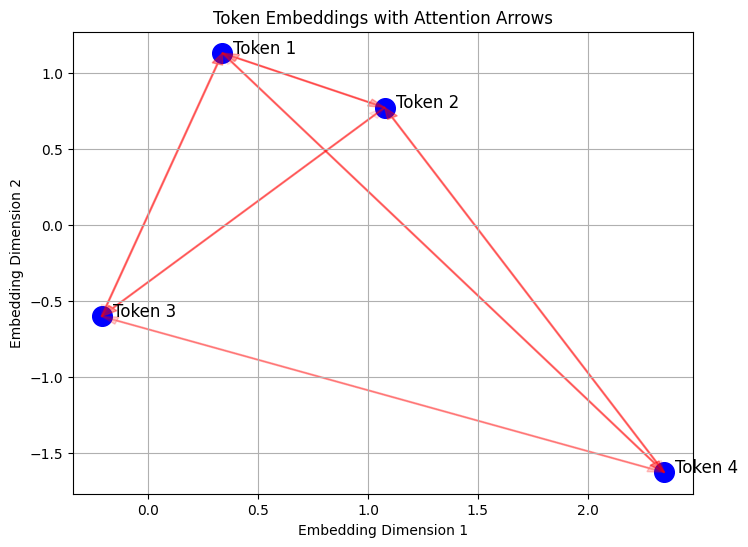

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Token embeddings (with positional embeddings)
token_embeddings = np.array([
    [ 0.3367,  1.1288],
    [ 1.0759,  0.7706],
    [-0.2136, -0.6025],
    [ 2.3493, -1.6280]
])

# Attention scores (indicating attention between tokens)
# Assume these are self-attention scores where each token attends to every other token
attention_scores = np.array([
    [0.2, 0.3, 0.1, 0.4],  # Token 1 attending to Tokens 1, 2, 3, and 4
    [0.3, 0.2, 0.4, 0.1],  # Token 2 attending to Tokens 1, 2, 3, and 4
    [0.4, 0.1, 0.3, 0.2],  # Token 3 attending to Tokens 1, 2, 3, and 4
    [0.1, 0.4, 0.2, 0.3]   # Token 4 attending to Tokens 1, 2, 3, and 4
])

# Create the scatter plot for token embeddings
plt.figure(figsize=(8, 6))
plt.scatter(token_embeddings[:, 0], token_embeddings[:, 1], color='blue', s=200)

# Annotate tokens on the plot
for i, (x, y) in enumerate(token_embeddings):
    plt.text(x + 0.05, y, f'Token {i+1}', fontsize=12)

# Add arrows to represent attention between tokens
for i in range(len(token_embeddings)):  # Source tokens
    for j in range(len(token_embeddings)):  # Target tokens
        if i != j:  # Avoid self-attention visualization (optional)
            plt.arrow(token_embeddings[i, 0], token_embeddings[i, 1],
                      token_embeddings[j, 0] - token_embeddings[i, 0],
                      token_embeddings[j, 1] - token_embeddings[i, 1],
                      color='red', alpha=attention_scores[i, j],
                      width=0.005, head_width=0.05, length_includes_head=True)

# Customize the plot
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Token Embeddings with Attention Arrows')
plt.grid(True)

# Show plot
plt.show()


In [ ]:
import numpy as np

# Attention score embeddings
attention_scores = np.array([
    [ 0.2008,  0.7272],
    [ 0.1184,  0.6732],
    [ 0.0761,  0.5607],
    [-0.1795,  0.3784]
])

# Compute the dot product matrix
dot_product_matrix = np.dot(attention_scores, attention_scores.T)
dot_product_matrix_softmax = F.softmax(torch.tensor(dot_product_matrix), dim=1)

# Display the result
print("Dot Product Matrix:")
print(dot_product_matrix)
print(dot_product_matrix_softmax)


Dot Product Matrix:
[[0.56914048 0.51332576 0.42302192 0.23912888]
 [0.51332576 0.4672168  0.38647348 0.23348608]
 [0.42302192 0.38647348 0.3201757  0.19850893]
 [0.23912888 0.23348608 0.19850893 0.17540681]]
tensor([[0.2834, 0.2680, 0.2449, 0.2037],
        [0.2784, 0.2659, 0.2452, 0.2105],
        [0.2728, 0.2630, 0.2462, 0.2180],
        [0.2569, 0.2554, 0.2467, 0.2410]], dtype=torch.float64)


# Model

In [24]:
import lightning as L
from torch import nn
from torch.optim import Adam

class DecoderOnlyTransformer(L.LightningModule):

    def __init__(self, num_tokens=4, d_model=2, max_len=6):

        super().__init__()

        ## We are set the seed so that you can get the same results as me.
        L.seed_everything(seed=42)


        # NOTE: that creating token ids/vocab is handled outside of transformer (such as word2vec, glove, BPE etc).
        # nn.Embeddings will initiate some random weights(similar to nn.Linear) w.r.t to token_id  and will be adjusted accordingly (training)
        # Also nn.Embeddings mapped the token_ids(ids are integer (0 - N) or total number of tokens) to weights.
        # That's why you will use the same model tokenizer everytime othewise the mapping will be different.
        # The the mapped weights will be adjusted during training (adjust representation).
        # num_embeddings x embedding_dim (4x2 = [[1,1], [2,2], .., ..])
        self.we = nn.Embedding(num_embeddings=num_tokens,
                               embedding_dim=d_model)

        self.pe = PositionEncodingWithLooping(d_model=d_model,
                                   max_len=max_len)


        self.self_attention = Attention(d_model=d_model)
        ## NOTE: In this simple example, we are not doing multi-head attention
        ## If we wanted to do multi-head attention, we could
        ## initailize more Attention objects like this...
        ##
        ## self.self_attention_2 = Attention(d_model=d_model)
        ## self.self_attention_3 = Attention(d_model=d_model)
        ##
        ## If d_model=2, then using 3 self_attention objects would
        ## result in d_model*3 = 6 self-attention values per token,
        ## so we would need to initialize
        ## a fully connected layer to reduce the dimension of the
        ## self attention values back down to d_model like this:
        ##
        ## self.reduce_attention_dim = nn.Linear(in_features=(num_attention_heads*d_model), out_features=d_model)

        ## Note: that we only have one layer which is also our output layer.
        ## Since we need to identify the output for each input/token.
        ## We need each token to be a one-hot encoding of all tokens available to our vocabulary
        ## [T1 [ 0.1416<T1>,  1.0208<T2>,  0.7418<T3>, -0.4908<T4>,  0.1990<T5>],
        ##  T2 [ 0.6305<T1>,  0.8153<T2>,  0.8407<T3>, -0.4216<T4>,  0.3690<T5>]
        ##  ..]
        ## Then we do argmax for each token to see what should be the output for each of the token.
        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, token_ids):
        word_embeddings = self.we(token_ids)
        position_encoded = self.pe(word_embeddings)

        ## For the decoder-only transformer, we need to use "masked self-attention" so that
        ## when we are training we can't cheat and look ahead at
        ## what words come after the current word.
        ## To create the mask we are creating a matrix where the lower triangle
        ## is filled with 0, and everything above the diagonal is filled with 0s.
        ## tensor([[1., 0., 0., 0.],
        ##         [1., 1., 0., 0.],
        ##         [1., 1., 1., 0.],
        ##         [1., 1., 1., 1.]])
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0)), device=self.device))

        ## We then replace the 0s above the digaonal, which represent the words
        ## we want to be masked out, with "True", and replace the 1s in the lower
        ## triangle, which represent the words we want to include when we calcualte
        ## self-attention for a specific word in the output, with "False".
        ## tensor([[False, True, True, True],
        ##         [False, False, True, True],
        ##         [False, False, False, True],
        ##         [False, False, False, False]])
        mask = mask == 0

        self_attention_values = self.self_attention(position_encoded,
                                                    mask=mask)

        ## Why do we need residual values?
        ## Check this youtube - https://www.youtube.com/watch?v=Q1JCrG1bJ-A.
        ## where it explained the importance of having residual connections.
        ## Also we have notes here - https://www.notion.so/ML-Engineer-paths-14f4f26dcdd24f63850a782c1cf367b9?pvs=4#1265a706faf280bb996fea8bd438514e
        ## The idea here is that tensors that goes to the layers just adds/augment to the original features of the input(barely modifying it).
        residual_connection_values = position_encoded + self_attention_values

        fc_layer_output = self.fc_layer(residual_connection_values)

        return fc_layer_output

    def configure_optimizers(self):
        ## configure_optimizers() simply passes the parameters we want to
        ## optimize to the optimzes and sets the learning rate
        return Adam(self.parameters(), lr=0.1)


    def training_step(self, batch, batch_idx):
        ## training_step() is called by Lightning trainer when
        ## we want to train the model.
        input_tokens, labels = batch # collect input
        output = self.forward(input_tokens[0])
        loss = self.loss(output, labels[0])
        print('loss', loss)
        return loss

## First, create a model from DecoderOnlyTransformer()
model = DecoderOnlyTransformer(num_tokens=len(token_to_id), d_model=2, max_len=6)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [25]:
def predict(model_input):
  input_length = model_input.size(dim=0)

  ## Now get get predictions from the model
  predictions = model(model_input)

  ## NOTE: "predictions" is the output from the fully connected layer,
  ##      not a softmax() function. We could, if we wanted to,
  ##      Run "predictions" through a softmax() function, but
  ##      since we're going to select the item with the largest value
  ##      we can just use argmax instead...
  ## ALSO NOTE: "predictions" is a matrix, with one row of predicted values
  ##      per input token. Since we only want the prediction from the
  ##      last row (the most recent prediction) we use reverse index for the
  ##      row, -1.
  predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
  print('predictions', predictions)
  print('predicted_id', predicted_id)

  ## We'll store predicted_id in an array, predicted_ids, that
  ## we'll add to each time we predict a new output token.
  predicted_ids = predicted_id

  ## Now use a loop to predict output tokens until we get an
  ## <EOS> token.
  max_length = 6
  for i in range(input_length, max_length):
      if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
          break

      model_input = torch.cat((model_input, predicted_id))

      predicted_id = model(model_input)
      predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
      predicted_ids = torch.cat((predicted_ids, predicted_id))

  ## Now printout the predicted output phrase.
  print("Predicted Tokens:\n")
  for id in predicted_ids:
      print("\t", id_to_token[id.item()])

In [ ]:
# @title Without training
## Now create the input for the transformer...
model_input = torch.tensor([token_to_id["what"],
                            token_to_id["is"],
                            token_to_id["life"],
                            token_to_id["<EOS>"]])
predict(model_input)

In [26]:
trainer = L.Trainer(max_epochs=30)
trainer.fit(model, train_dataloaders=dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type                        | Params | Mode 
-----------------------------------------------------------------------
0 | we             | Embedding                   | 10     | train
1 | pe             | PositionEncodingWithLooping | 0      | train
2 | self_attention | Attention                   | 12     | train
3 | fc_layer       | Linear                      | 15     | train
4 | loss           | CrossEntropyLoss            | 0      | train
-----------------------------------------------------------------------
37        Trainable params
0         Non-trainable params
37        Total params
0.0

Training: |          | 0/? [00:00<?, ?it/s]

loss tensor(1.5605, grad_fn=<NllLossBackward0>)
loss tensor(1.4294, grad_fn=<NllLossBackward0>)
loss tensor(1.1268, grad_fn=<NllLossBackward0>)
loss tensor(1.1016, grad_fn=<NllLossBackward0>)
loss tensor(0.8029, grad_fn=<NllLossBackward0>)
loss tensor(0.8191, grad_fn=<NllLossBackward0>)
loss tensor(0.5388, grad_fn=<NllLossBackward0>)
loss tensor(0.6120, grad_fn=<NllLossBackward0>)
loss tensor(0.3584, grad_fn=<NllLossBackward0>)
loss tensor(0.4725, grad_fn=<NllLossBackward0>)
loss tensor(0.2465, grad_fn=<NllLossBackward0>)
loss tensor(0.3799, grad_fn=<NllLossBackward0>)
loss tensor(0.1891, grad_fn=<NllLossBackward0>)
loss tensor(0.3174, grad_fn=<NllLossBackward0>)
loss tensor(0.1612, grad_fn=<NllLossBackward0>)
loss tensor(0.2618, grad_fn=<NllLossBackward0>)
loss tensor(0.1517, grad_fn=<NllLossBackward0>)
loss tensor(0.2042, grad_fn=<NllLossBackward0>)
loss tensor(0.1630, grad_fn=<NllLossBackward0>)
loss tensor(0.1766, grad_fn=<NllLossBackward0>)
loss tensor(0.1758, grad_fn=<NllLossBack

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


loss tensor(0.0264, grad_fn=<NllLossBackward0>)
loss tensor(0.1352, grad_fn=<NllLossBackward0>)
loss tensor(0.0237, grad_fn=<NllLossBackward0>)
loss tensor(0.1276, grad_fn=<NllLossBackward0>)
loss tensor(0.0226, grad_fn=<NllLossBackward0>)
loss tensor(0.0872, grad_fn=<NllLossBackward0>)
loss tensor(0.0218, grad_fn=<NllLossBackward0>)
loss tensor(0.0508, grad_fn=<NllLossBackward0>)


In [27]:
# @title After training
## Now create the input for the transformer...
model_input = torch.tensor([token_to_id["what"],
                            token_to_id["is"],
                            token_to_id["life"],
                            token_to_id["<EOS>"]])
predict(model_input)

predictions tensor([[ -1.5503,   8.6861,   0.8554,   1.4063, -10.6343],
        [  7.8719,   4.8554,  10.2138, -11.1490,  -8.9896],
        [ -4.1358,  -3.6899,  -6.4874,   8.0023,   1.9360],
        [  3.6551, -13.2122,  -1.0089,  -0.8882,   9.4588]],
       grad_fn=<AddmmBackward0>)
predicted_id tensor([4])
Predicted Tokens:

	 awesome
	 awesome
	 awesome


In [28]:
## Now create the input for the transformer...
model_input = torch.tensor([token_to_id["life"],
                            token_to_id["is"],
                            token_to_id["what"],
                            token_to_id["<EOS>"]])
predict(model_input)

predictions tensor([[ -0.8139,  11.5731,   2.7198,  -0.3226, -13.5959],
        [  4.5409,  -5.9097,   2.5957,  -3.8665,   2.1823],
        [ -4.5077,  -5.2312,  -7.4587,   8.8950,   3.5125],
        [  3.3993, -13.8991,  -1.5442,  -0.3618,  10.1812]],
       grad_fn=<AddmmBackward0>)
predicted_id tensor([4])
Predicted Tokens:

	 awesome
	 awesome
	 awesome
